In [ ]:
val x:Int = 0

Intitializing Scala interpreter ...

Spark Web UI available at http://172.21.147.132:4040
SparkContext available as 'sc' (version = 3.3.1, master = local[*], app id = local-1670087572185)
SparkSession available as 'spark'


x: Int = 0


# Zad.1 Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków.

In [ ]:
import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD

import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.sql._
import org.apache.spark.rdd.RDD


In [ ]:
val sc = (
    SparkContext
    .getOrCreate(
        new SparkConf()
        .setAppName("GraphX lab")
        .setMaster("local[*]")
    )
)

val vertices: RDD[(Long, (String, String))] = (
    sc.textFile("facebook_large/musae_facebook_target.csv")
    .map(line => {
        val x = line.split(",");
        (x(0).toLong, (x(2), x(3)))
    })
)

val edges: RDD[Edge[String]] = (
    sc.textFile("facebook_large/musae_facebook_edges.csv")
    .map(line => {
        val x = line.split(",");
        Edge(x(0).toLong, x(1).toLong, "")
    })
)

val default_node = ("", "")

val graph: Graph[(String, String), String] = Graph(vertices, edges, default_node)

22/12/03 18:37:37 WARN SparkContext: Using an existing SparkContext; some configuration may not take effect.


sc: org.apache.spark.SparkContext = org.apache.spark.SparkContext@65551f6c
vertices: org.apache.spark.rdd.RDD[(Long, (String, String))] = MapPartitionsRDD[48] at map at <console>:52
edges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[String]] = MapPartitionsRDD[51] at map at <console>:60
default_node: (String, String) = ("","")
graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@37616c2


In [ ]:
graph.vertices.count()

res3: Long = 22470


In [ ]:
graph.edges.count()

res4: Long = 171002


# Zad.2 Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony governmental organizations oraz television shows też są spójne?

In [ ]:
def isConnected(graph: Graph[(String, String), String]): Boolean =
    graph.vertices.count() == graph.connectedComponents().vertices.count()

isConnected: (graph: org.apache.spark.graphx.Graph[(String, String),String])Boolean


In [ ]:
println(isConnected(graph))

true


In [ ]:
val government_graph = graph.subgraph(
    vpred = { case (id, (page_name, page_type)) => page_type == "government" }
)

println(isConnected(government_graph))

true


government_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@3e87757a


In [ ]:
val tvshow_graph = graph.subgraph(
    vpred = { case (id, (page_name, page_type)) => page_type == "tvshow" }
)

println(isConnected(tvshow_graph))

true


tvshow_graph: org.apache.spark.graphx.Graph[(String, String),String] = org.apache.spark.graphx.impl.GraphImpl@5cb2eb27


# Zad.3 Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot)

In [ ]:
val ranks = graph.pageRank(0.0001).vertices

val rankedVertexDegrees = ranks.join(graph.degrees)

ranks: org.apache.spark.graphx.VertexRDD[Double] = VertexRDDImpl[2121] at RDD at VertexRDD.scala:57
rankedVertexDegrees: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, (Double, Int))] = MapPartitionsRDD[2134] at join at <console>:39


In [ ]:
rankedVertexDegrees.takeSample(false, 3)

res10: Array[(org.apache.spark.graphx.VertexId, (Double, Int))] = Array((21621,(5.383946245119022,17)), (6718,(0.3715027271414795,2)), (7725,(0.40308045894850536,1)))


In [ ]:
val graphWithRankedDegrees = graph.outerJoinVertices(rankedVertexDegrees) {
    (_, data, vertexWithRank) => (
        data._1,  // page_name
        data._2,  // page_type
        vertexWithRank.getOrElse((0.0, 0))._1,  // PageRank value
        vertexWithRank.getOrElse((0.0, 0))._2   // degree
    )
}

graphWithRankedDegrees: org.apache.spark.graphx.Graph[(String, String, Double, Int),String] = org.apache.spark.graphx.impl.GraphImpl@12d39df9


In [ ]:
graphWithRankedDegrees.vertices.takeSample(false, 3)

res11: Array[(org.apache.spark.graphx.VertexId, (String, String, Double, Int))] = Array((17328,("Dr. Mathias Middelberg," MdB"",3.3033327312721674,61)), (22430,(Imovelweb,company,1.710729203883163,5)), (11501,(Vodafone Australia,company,0.5734436878164402,16)))


In [ ]:
val top_50 = (
    graphWithRankedDegrees.vertices
    .top(50)
    .map(v => (v._2._2, v._2._1))  // degree, page_type, page_name
    .sorted
)


val last_50 = (
    graphWithRankedDegrees.vertices
    .takeOrdered(50)
    .map(v => (v._2._2, v._2._1))  // degree, page_type, page_name
    .sorted
)

top_50: Array[(String, String)] = Array((" Chapters and Coles"","Indigo), (" Georgetown)"","India in Guyana (High Commission of India), (" Wissenschaft & Digitale Gesellschaft"","Thüringer Ministerium für Wirtschaft), (company,Abarth), (company,Bosch Professional Power Tools and Accessories), (company,CVS Pharmacy), (company,Cathay Pacific Airways), (company,Chupa Chups), (company,Dignity Health), (company,GIORDANO), (company,Imovelweb), (company,Keurig), (company,OLTURSA), (company,Pizzaro), (company,Tottus Perú), (company,Triumph), (company,Yenda), (company,dubdub Stories), (government,Ambassade du Canada en Israël), (government,Australia in Thailand), (government,Camden County Government), (government,City of Los Altos Police Department), (government,EnergySaver.gov), (government,Flo...


In [ ]:
top_50.foreach(println)

( Chapters and Coles","Indigo)
( Georgetown)","India in Guyana (High Commission of India)
( Wissenschaft & Digitale Gesellschaft","Thüringer Ministerium für Wirtschaft)
(company,Abarth)
(company,Bosch Professional Power Tools and Accessories)
(company,CVS Pharmacy)
(company,Cathay Pacific Airways)
(company,Chupa Chups)
(company,Dignity Health)
(company,GIORDANO)
(company,Imovelweb)
(company,Keurig)
(company,OLTURSA)
(company,Pizzaro)
(company,Tottus Perú)
(company,Triumph)
(company,Yenda)
(company,dubdub Stories)
(government,Ambassade du Canada en Israël)
(government,Australia in Thailand)
(government,Camden County Government)
(government,City of Los Altos Police Department)
(government,EnergySaver.gov)
(government,Florida Division of Historical Resources)
(government,Memphis VA Medical Center)
(government,Michigan Department of Agriculture & Rural Development - MDARD)
(government,Ministerio del Interior - Paraguay)
(government,Monroe County Sheriff's Office)
(government,NYPD 33rd Prec

In [ ]:
last_50.foreach(println)

(company,Die Techniker (TK))
(company,Digicel)
(company,ESET)
(company,Ford Danmark)
(company,Honey Bunches of Oats)
(company,Hotel Indigo)
(company,Hydro Coco)
(company,Marriott Rewards)
(company,Omoda)
(company,Schweppes Australia)
(company,Shapeways)
(company,Sunrun)
(company,Tahiti Tourisme)
(company,TalkTalk)
(company,TeleCentro)
(company,Volaris)
(government,1st Armored Division Sustainment Brigade)
(government,Army ROTC Fighting Saints Battalion)
(government,Brisbane Water LAC - NSW Police Force)
(government,Consulate General of Switzerland in Montreal)
(government,Embassy of the Netherlands in Uganda)
(government,Ministerio de Comunicaciones de la República Argentina)
(government,Municipio de Lomas de Zamora)
(government,NASA Student Launch)
(government,NASA's Marshall Space Flight Center)
(government,NCBI - National Center for Biotechnology Information)
(government,National Institute of General Medical Sciences)
(government,Nuevo León Extraordinario)
(government,Policía Nacion

In [ ]:
val rankedVertexDegreesValues = (
    rankedVertexDegrees
    .map(v => (v._2._1, v._2._2))
)

rankedVertexDegreesValues.takeSample(false, 3)

rankedVertexDegreesValues: org.apache.spark.rdd.RDD[(Double, Int)] = MapPartitionsRDD[2144] at map at <console>:39
res14: Array[(Double, Int)] = Array((0.3715027271414795,2), (0.3715027271414795,2), (5.072800585844387,67))


In [ ]:
import java.io._

val file = "degree_pagerank.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(rankedVertexDegreesValues.collect().mkString(","))
writer.close()

import java.io._
file: String = degree_pagerank.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@3756dde5


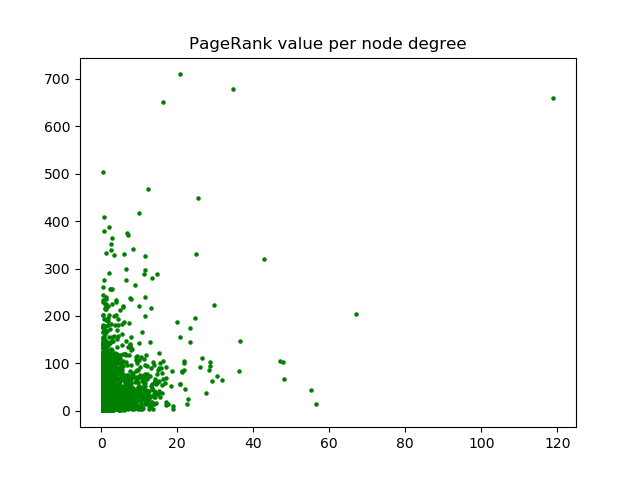

In [ ]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
from IPython.display import Image

with open("degree_pagerank.txt") as file:
    text = file.read()

tuples = [tup[:-1] for tup in text.split(",(")]
tuples[0] = tuples[0][1:]
tuples = [tup.split(",") for tup in tuples]
tuples = [(int(tup[1]), float(tup[0])) for tup in tuples]
tuples.sort()

degrees = [degree for pagerank_value, degree in tuples]
pagerank_values = [pagerank_value for pagerank_value, degree in tuples]

plt.clf()
plt.scatter(degrees, pagerank_values, c="green", s=5)
plt.title("PageRank value per node degree")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

# Zad.4 Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez 1/4 losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane 1/4 jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków.

In [ ]:
import scala.language.implicitConversions

implicit def bool2int(b:Boolean) = if (b) 1 else 0


def getPublishersNumber(graph: graphx.Graph[Boolean,String], maxIter: Int): Int = {
    val publishGraph = Pregel(
        graph,
        false,
        maxIter,
        activeDirection = EdgeDirection.Out
    )(
        (id, value, msg) => value || (msg && (scala.util.Random.nextFloat() < 0.25)),
        triplet => Iterator((triplet.dstId, triplet.srcAttr)),
        (a, b) => a || b
    )
    
    publishGraph.vertices.collect().map(v => v._2 * 1).sum
}

import scala.language.implicitConversions
bool2int: (b: Boolean)Int
getPublishersNumber: (graph: org.apache.spark.graphx.Graph[Boolean,String], maxIter: Int)Int


In [ ]:
val publishId = 1
val initialGraph = ((publishId: VertexId) => graph.mapVertices((id, _) => id == publishId))(publishId)

val publisherNumbers = for (maxIter <- 1 to 32) yield getPublishersNumber(initialGraph, maxIter)

22/12/03 19:06:37 WARN BlockManager: Block rdd_11110_1 already exists on this machine; not re-adding it
22/12/03 19:06:37 WARN BlockManager: Block rdd_11110_0 already exists on this machine; not re-adding it


publishId: Int = 1
initialGraph: org.apache.spark.graphx.Graph[Boolean,String] = org.apache.spark.graphx.impl.GraphImpl@1fef0f07
publisherNumbers: scala.collection.immutable.IndexedSeq[Int] = Vector(9, 68, 250, 354, 660, 1458, 2078, 2340, 3689, 3356, 3450, 3632, 3961, 4082, 5787, 6145, 3397, 5701, 4904, 6063, 6018, 7867, 5827, 6439, 6572, 6783, 6097, 7860, 3533, 6870, 8351, 8143)


In [ ]:
import java.io._

val file = "publisher_numbers.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(publisherNumbers.mkString(","))
writer.close()

import java.io._
file: String = publisher_numbers.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@43ed676d


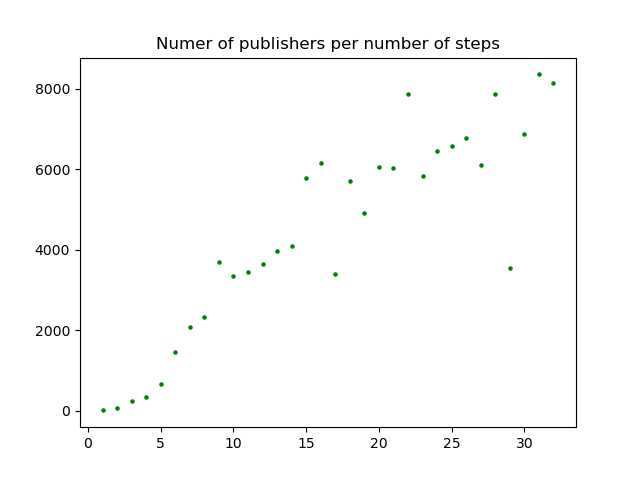

In [ ]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
from IPython.display import Image

with open("publisher_numbers.txt") as file:
    text = file.read()

xs = list(range(1, 33))
ys = [int(val) for val in text.split(",")]

plt.clf()
plt.scatter(xs, ys, c="green", s=5)
plt.title("Numer of publishers per number of steps")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

# Zad.5 Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z funkcji obliczającej histogram dla RDD. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf

In [ ]:
val degrees = graph.degrees.map(v => v._2)

degrees.takeSample(false, 10)

degrees: org.apache.spark.rdd.RDD[Int] = MapPartitionsRDD[20074] at map at <console>:45
res17: Array[Int] = Array(8, 4, 2, 3, 1, 19, 5, 3, 29, 93)


In [ ]:
val (bins, values) = degrees.histogram(degrees.max)

bins: Array[Double] = Array(1.0, 1.998589562764457, 2.997179125528914, 3.9957686882933707, 4.994358251057828, 5.992947813822285, 6.9915373765867415, 7.990126939351199, 8.988716502115656, 9.987306064880112, 10.98589562764457, 11.984485190409027, 12.983074753173483, 13.981664315937941, 14.980253878702397, 15.978843441466855, 16.97743300423131, 17.97602256699577, 18.974612129760224, 19.973201692524682, 20.97179125528914, 21.970380818053595, 22.968970380818053, 23.96755994358251, 24.966149506346966, 25.964739069111424, 26.963328631875882, 27.96191819464034, 28.960507757404795, 29.959097320169253, 30.95768688293371, 31.956276445698165, 32.95486600846262, 33.95345557122708, 34.95204513399154, 35.950634696756, 36.94922425952045, 37.94781382228491, 38.946403385049365, 39.94499294781382, 40.9435...


In [ ]:
import java.io._

val file = "histogram_values.txt"
val writer = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(file)))

writer.write(values.mkString(","))
writer.close()

import java.io._
file: String = histogram_values.txt
writer: java.io.BufferedWriter = java.io.BufferedWriter@68b495ff


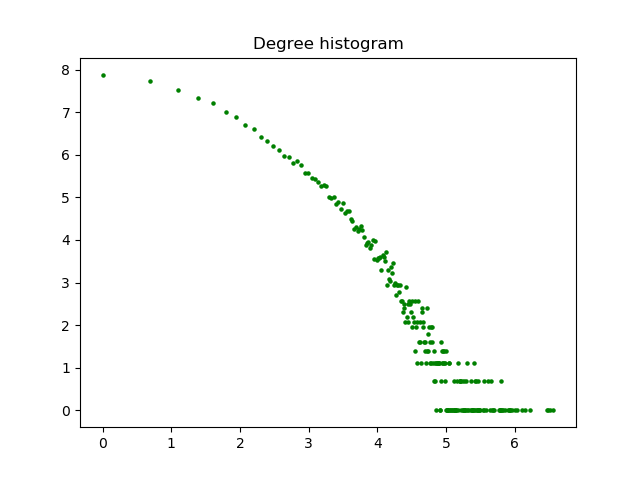

In [ ]:
%%python
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

with open("histogram_values.txt") as file:
    text = file.read()

ys = np.array([int(val) for val in text.split(",")])
xs = list(range(1, len(ys) + 1))

plt.clf()
plt.scatter(np.log(xs), np.log(ys), color="green", s=5)
plt.title("Degree histogram")

with NamedTemporaryFile(suffix=".png", delete=False) as file:
    plt.savefig(file.name)
    retval = Image(filename=file.name)

# https://mathinsight.org/scale_free_network